Epoch 1, Loss: 1.1764
Epoch 101, Loss: 0.0486
Epoch 201, Loss: 0.0033
Epoch 301, Loss: 0.0011
Epoch 401, Loss: 0.0005
Epoch 501, Loss: 0.0003
Epoch 601, Loss: 0.0002
Epoch 701, Loss: 0.0001
Epoch 801, Loss: 0.0001
Epoch 901, Loss: 0.0001
Epoch 1001, Loss: 0.0001
Epoch 1101, Loss: 0.0001
Epoch 1201, Loss: 0.0000
Epoch 1301, Loss: 0.0000
Epoch 1401, Loss: 0.0000
Epoch 1501, Loss: 0.0000
Epoch 1601, Loss: 0.0000
Epoch 1701, Loss: 0.0000
Epoch 1801, Loss: 0.0000
Epoch 1901, Loss: 0.0000


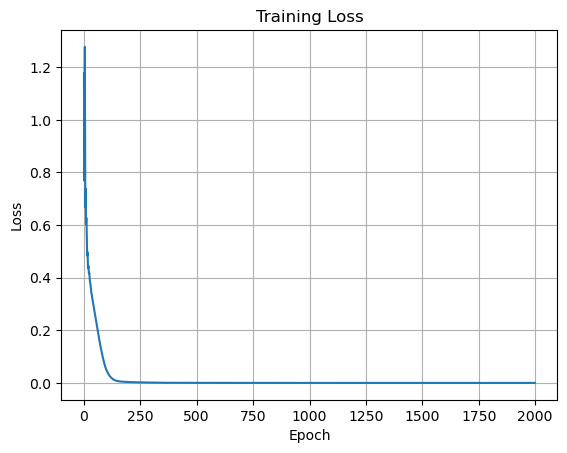


Test Accuracy: 89.00%


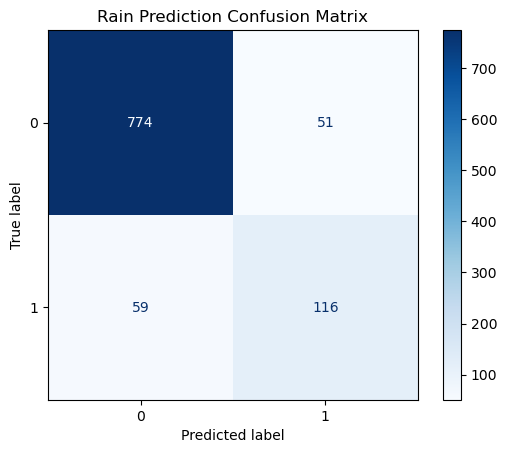

              precision    recall  f1-score   support

     No Rain       0.93      0.94      0.93       825
        Rain       0.69      0.66      0.68       175

    accuracy                           0.89      1000
   macro avg       0.81      0.80      0.81      1000
weighted avg       0.89      0.89      0.89      1000



In [47]:
# Rain Prediction with PyTorch RNN

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


# 1. Generate synthetic weather data
def generate_weather_data(num_samples=5000, seq_length=6):
    X, Y = [], []
    for _ in range(num_samples):
        seq = []
        for _ in range(seq_length):
            temp = np.random.uniform(15, 30)
            humidity = np.random.uniform(30, 100)
            wind = np.random.uniform(0, 10)
            cloud = np.random.uniform(0, 1)
            pressure = np.random.uniform(990, 1025)
            precip = np.random.uniform(0, 1)
            seq.append([temp, humidity, wind, cloud, pressure, precip])
        seq = np.array(seq)
        last = seq[-3:]
        avg_humidity = np.mean(last[:, 1])
        avg_cloud = np.mean(last[:, 3])
        avg_pressure = np.mean(last[:, 4])
        rain = 1 if avg_humidity > 70 and avg_cloud > 0.5 and avg_pressure < 1050 else 0
        X.append(seq)
        Y.append(rain)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32).unsqueeze(1)

# 2. Load dataset
X, Y = generate_weather_data()
def normalize_features(X):
    mean = X.mean(dim=(0, 1), keepdim=True)
    std = X.std(dim=(0, 1), keepdim=True)
    return (X - mean) / (std + 1e-8)

X = normalize_features(X)

train_X, test_X = X[:4000], X[4000:]
train_Y, test_Y = Y[:4000], Y[4000:]

# 3. Define the RNN model
class RainRNN(nn.Module):
    def __init__(self, input_size=6, hidden_size=32):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return (self.fc(out[:, -1, :]))

# 4. Train the model
model = RainRNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

losses = []
for epoch in range(2000):
    model.train()
    optimizer.zero_grad()
    output = model(train_X)
    
    # Calculate positive class weight (inversely proportional to class frequency)
    pos_weight = (train_Y == 0).sum() / (train_Y == 1).sum()
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    loss = criterion(output, train_Y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 100 == 0: print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# 5. Plot training loss
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

# 6. Evaluate on test set
model.eval()
with torch.no_grad():
    preds = model(test_X)
    predicted_classes = (preds > 0.5).int()
    correct = (predicted_classes == test_Y.int()).sum().item()
    test_acc = correct / test_Y.size(0)
    print(f"\nTest Accuracy: {test_acc:.2%}")

# 7. Plot confusion matrix
cm = confusion_matrix(test_Y.numpy(), predicted_classes.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Rain Prediction Confusion Matrix")
plt.show()
print(classification_report(test_Y.numpy(), predicted_classes.numpy(), target_names=["No Rain", "Rain"]))